In [1]:
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import graphviz
# Data-preprocessing for quantitative/qualitative transformation
from sklearn import preprocessing
# Cross-validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
# Machine Learning models
from sklearn import linear_model
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, \
RandomForestClassifier, GradientBoostingClassifier
# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Task
The task comes down to predicting whether the person makes over 50K a year (`V14` a binary qualitative variable). [more info](https://archive.ics.uci.edu/ml/datasets/adult)  

First of all upload the dataframe `df`. We are going to use it for fitting our predictive model. This dataset will separate onto train set and test set. Also we use this dataset for finding best hyperparameters by means of cross-validation. Also we'll get the cross-validation error rate and test error rate on the X_test set.

In [2]:
df = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=',', engine='python', na_values=' ?', header=None)

In [3]:
left_out_df = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', sep=',', engine='python', na_values=' ?', skiprows=1, header=None)

In [4]:
left_out_df.shape

(16281, 15)

For getting an unbiased test error rate each of the predictive model will predict on `left_out_df` dataset and has a shape `(16284, 15)`. It's half volume of the `df` dataset. In **predictive models** chapter we use `left_out_df` dataset for getting final accuracy score for each predictive model.

# Preliminarily analysis

The dataframe **df** contains 15 variables (`V0` to `V14`) and 32561 observations.  
There are 6 continuous variables: `V0`(age), `V2`(final weight), `V4`(ed num), `V10`(capital gain), `V11`(capital loss) and `V12` (hours per week)  
And 8 qualitative variables: `V1`(workplace), `V3`(education), `V5`(marital status), `V6`-(occupation), `V7`(ralationship), `V8`(race), `V9`(sex), `V13`(native-country)

In [5]:
df.shape

(32561, 15)

In [6]:
df.info(),
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
0     32561 non-null int64
1     30725 non-null object
2     32561 non-null int64
3     32561 non-null object
4     32561 non-null int64
5     32561 non-null object
6     30718 non-null object
7     32561 non-null object
8     32561 non-null object
9     32561 non-null object
10    32561 non-null int64
11    32561 non-null int64
12    32561 non-null int64
13    31978 non-null object
14    32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There are missed values in variables indicated by **"?"**. For prediction purpose we should either fill each of them with median value for corresponding variable or just leave this observations out from the dataframe. Cause the dataframe is large enough we can just leave out the observations with missed values. The quantity of observations decresed from 32561 to 30162

In [7]:
df.dropna(inplace=True),
df.shape

(30162, 15)

In [8]:
left_out_df.dropna(inplace=True),
left_out_df.shape

(15060, 15)

## Baseline

Lets glance at the distribution of the qualitative variables

In [9]:
df.describe(include=['object', 'bool'])

,1,3,5,6,7,8,9,13,14
count,30162,30162,30162,30162,30162,30162,30162,30162,30162
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22286,9840,14065,4038,12463,25933,20380,27504,22654


As we can see, our dependent binary variable `V14` has 22654 (income less than 50K) out of 30162 observations. Thus, using naive model which always gonna predict the income under 50K, the probability of the right answer will be $P(V14\leq50K|x)=0.75$.  So the baseline for our model is **0.75**

## Correlation

Compute the correlation between variables. First of all dummy variables have to be created before computing a correlation matrix

In [10]:
dummy_df = df.apply(preprocessing.LabelEncoder().fit_transform)

In [11]:
dummy_df.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.080625,-0.078136,-0.001099,0.043544,-0.276612,-0.005658,-0.246619,0.023428,0.082036,0.127099,0.066324,0.102539,-0.001891,0.242194
1,0.080625,1.000000,-0.035851,0.017855,0.037833,-0.034241,0.015572,-0.067417,0.044731,0.074973,0.022784,0.011611,0.049040,0.007668,0.018044
2,-0.078136,-0.035851,1.000000,-0.025343,-0.043944,0.034088,0.002012,0.006879,-0.012034,0.024581,-0.005102,-0.009561,-0.024572,-0.070091,-0.009961
3,-0.001099,0.017855,-0.025343,1.000000,0.345410,-0.040664,-0.038212,-0.012717,0.011154,-0.027888,0.032220,0.014868,0.060630,0.078790,0.078987
4,0.043544,0.037833,-0.043944,0.345410,1.000000,-0.063419,0.087717,-0.091935,0.032805,0.006157,0.154461,0.083858,0.154684,0.091555,0.335286
5,-0.276612,-0.034241,0.034088,-0.040664,-0.063419,1.000000,0.022655,0.177964,-0.068627,-0.119813,-0.072145,-0.035862,-0.191255,-0.025902,-0.193518
6,-0.005658,0.015572,0.002012,-0.038212,0.087717,0.022655,1.000000,-0.053727,0.000717,0.062313,0.018086,0.013888,0.017498,-0.003483,0.051577
7,-0.246619,-0.067417,0.006879,-0.012717,-0.091935,0.177964,-0.053727,1.000000,-0.117143,-0.584876,-0.092805,-0.066304,-0.260493,-0.010809,-0.251003
8,0.023428,0.044731,-0.012034,0.011154,0.032805,-0.068627,0.000717,-0.117143,1.000000,0.089186,0.025729,0.023370,0.049019,0.124514,0.071658
9,0.082036,0.074973,0.024581,-0.027888,0.006157,-0.119813,0.062313,-0.584876,0.089186,1.000000,0.078458,0.050946,0.233432,0.000618,0.216699


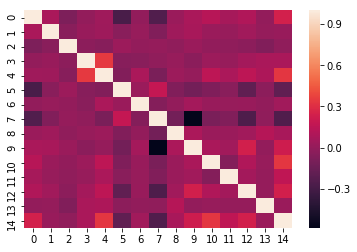

In [12]:
sns.heatmap(dummy_df.corr());

Even though correlation matrix didn't give us a strong evidence about correlation between variables we might expect a value of the correlation between `V3` and `V4` will be approximately 1, cause it's the same but quantitative variable. In addition correlation matrix doesn't take into account a multicollinearity (for example `V2` is social coefficient derived from another variables). So we can exclude `V2` and `V4` from the dataset.

In [13]:
df.drop([2, 4], axis=1, inplace=True)

In [14]:
left_out_df.drop([2, 4], axis=1, inplace=True)

## Variable-transformation

V13 qualitative variables too sparsed (41 factors). Most of the person have have Unites-States sitizenship.

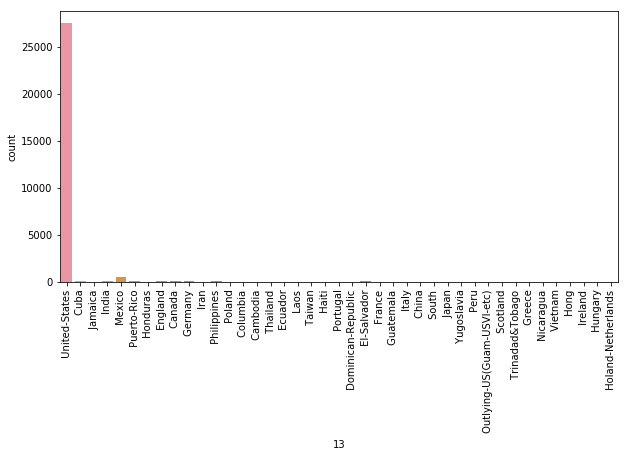

In [15]:
plt.figure(figsize=(10,5))
ax = sns.countplot(df[13]);
# avoid overlapping
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.show()

For this reason the best solution is to transform this qualitative variable with 41 factors into binary variable **United-States/Others**

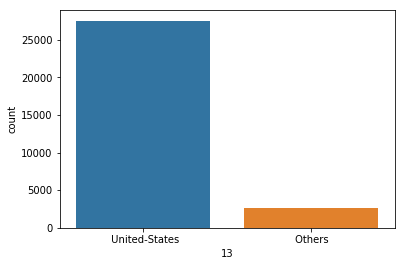

In [16]:
df.loc[df[13] != ' United-States', 13] = ' Others';
left_out_df.loc[left_out_df[13] != ' United-States', 13] = ' Others';
sns.countplot(df[13]);

`V3` represents education of the person. Cause our dependent variable `V14` is an income per year, it is a reasonable assumption that there is no difference between 1st-4th, 5th-6th, 7th-8th, 9th, Preschool, 10th, 11th and 12th in terms of the income. For this reason we substitute all of them by factor *"Primary education"* left another factors intact.

In [17]:
df.loc[df[3].isin([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th',
                   ' 7th-8th', ' 9th', ' Preschool']), 3] = ' Primary education'

In [18]:
left_out_df.loc[left_out_df[3].isin([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th',
                   ' 7th-8th', ' 9th', ' Preschool']), 3] = ' Primary education'

For better interpretability transform a continuous variable `V0` into qualitative variable with 4 factors: `Young, Middle-aged, Senior and Old`

In [19]:
df[0] = pd.cut(df[0], [15, 25, 45, 65, 100],
               labels=[' Young', ' Middle-aged', ' Senior', ' Old'])

In [20]:
left_out_df[0] = pd.cut(left_out_df[0], [15, 25, 45, 65, 100],
               labels=[' Young', ' Middle-aged', ' Senior', ' Old'])

In order to get an unbiased accuracy, the dataset should be splited on training set and test set. Also we separate dependent variable from dataset and store it in `y`. A train/test proporstion is 80/20

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 0:13],
                                                df[14], test_size=0.2, random_state=17)

In [22]:
left_out_X, left_out_y = left_out_df.loc[:,0:13], left_out_df[14]

Suddenly, I came across a marking problem. The fact is that in left-out set the response variable `V14` have a dot at the end of the each observation (`>50K.`. instead of  `>50K`). It'll lead to problem when we make an accuracy score. So the trasformation has to be made as follow:

In [23]:
left_out_y = left_out_y.map({' >50K.': ' >50K', ' <=50K.': ' <=50K'})

# Predictive models

## Logit

Use the linear model for predicting the accuracy. I ignore `L1 regularization` on purpose. The main target now is to use a simple model without setting hyperparametrers and look for an accuracy score as a kind of baseline. As the linear model is required a numerical input, the first step is to transform observations from train/test matrix into dummy variables.

In [132]:
dummy_X_train = X_train.apply(preprocessing.LabelEncoder().fit_transform)
dummy_X_test = X_test.apply(preprocessing.LabelEncoder().fit_transform)
dummy_left_out_X = left_out_X.apply(preprocessing.LabelEncoder().fit_transform)

In [133]:
logit = linear_model.LogisticRegression(penalty='l1',random_state=17, n_jobs=-1)

The logit model has to be fitted on a training test only so as to get unbiased estimation. Afterwards the fitted model should predict a result on a test set.

In [134]:
logit.fit(dummy_X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [135]:
predictions = logit.predict(dummy_X_test)

Finally, the accuracy of the model should be estimated using convinient metric. For classification purpose we use `accuracy score`. It just matches fitted model result to test test and represents percentage of correct observations throughout all observations. It's essential not to use `y_test` for fitted model in order to get test error rate. Otherwise the training error rate will be recieved.

In [136]:
pd.crosstab(y_test, predictions)

col_0,<=50K,>50K
14,,
<=50K,4351,153
>50K,1147,382


In [137]:
accuracy_score(y_test, predictions)

0.7845184816840709

The indisputable advantage of the linear model is interpretability. We are interersted in a weight of each independent variables in order to look which of them affects more than another. a `coef_` attribute gives us a vector $\beta$

In [138]:
logit.coef_

array([[-0.09075934, -0.05655482, -0.09015173, -0.26059651,  0.02153688,
        -0.21278987,  0.08410997,  0.59588915,  0.03153142,  0.03366089,
         0.030676  ,  0.21666454]])

The coefficients can be interpreted as follow: Being a male increases the `log-odds` of make over 50K on 0.59 units holding all other variables constant. In other words, the probability of having an income over 50K more likely for men rather than women. By default the propabilistic threshould equals 0.5.

In [139]:
import statsmodels.api as sm
from scipy import stats

X = dummy_X_train
y = y_train.map({' >50K': 1, ' <=50K': 0})

X2 = sm.add_constant(X)
est = sm.GLM(y, X, family=sm.families.Binomial())
est2 = est.fit()
print(est2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     14   No. Observations:                24129
Model:                            GLM   Df Residuals:                    24117
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -10723.
Date:                Thu, 08 Feb 2018   Deviance:                       21446.
Time:                        10:12:39   Pearson chi2:                 2.44e+04
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
0             -0.1142      0.015     -7.421      0.000        -0.144    -0.084
1             -0.1225      0.017     -7.029      0.0

## Lasso

Now the logistic regression will be used with L1 regularization. It allows us to get rid of unsignificant coefficients made them equals zero. In order to find the best hyperparameters we use 5-fold cross-validation. There is only 1 hyperparameter `C` which equals $1/\lambda$.

The lower `C` the stronger regularization occurs. We set a grid of `C` with various values and for each of them make a 5-fold CV.

In [32]:
logit_parameters = {'C': np.array([1e-06, 1e-05, 1e-04, 1e-03,
                                   1e-02, 0.1, 1, 10, 50, 100, 200, 1000])}

As an estimator we gonna use `logit` from section below. By default regularization for logistic regression is `L2`. So if you want to change this behavior the `penalty=l1` should be written in parameters of the estimator

In [33]:
logit_cv = GridSearchCV(logit, logit_parameters, cv=5, scoring='accuracy', n_jobs=-1)

In [34]:
%%time
logit_cv.fit(dummy_X_train, y_train)

CPU times: user 693 ms, sys: 360 ms, total: 1.05 s
Wall time: 12.5 s


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         5.00000e+01,   1.00000e+02,   2.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

After fitting the model with different values of `C`, the best hyperparameter has been found. $С=0.001$. For this value the best score equals:

In [35]:
print('C:', logit_cv.best_estimator_.C, 'Accuracy:', logit_cv.best_score_)

C: 0.001 Accuracy: 0.801027808861


The accuracy increased by 2%. Some of you might this that it's not worth-improving. This is not true cause we could decrease a quantity of the variables as well.

In [36]:
logit_cv.best_estimator_.coef_

array([[ 0.        ,  0.        , -0.11661685, -0.2433126 ,  0.        ,
        -0.2736056 ,  0.        ,  0.        ,  0.02949364,  0.030279  ,
         0.00233841,  0.        ]])

We can leave out 6 variables after L1 regularization. Unlike L2, L1-regularization make a variable strictly equals to zero.

We've got the `cv error rate` so far. Finally, compute accuracy score for fitted model with L1 regularization on the left-out dataset with the best value of hyperparameter `C=0.001` to get unbiased result

In [37]:
logit = linear_model.LogisticRegression(penalty='l1', C=0.001, random_state=17, n_jobs=-1)

In [38]:
logit.fit(dummy_X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
logit_pred = logit.predict(dummy_left_out_X)

In [40]:
accuracy_score(left_out_y, logit_pred)

0.79641434262948207

## Decision tree

Now we are gonna grow tree. The main advantage of decision tree comes down to interpretability. It's even better than logistic regression. As a tunned hyperparameter we use `max_depth`. As a criterion we use `Gini Index`.

In [41]:
tuned_param_tree = {'max_depth': np.arange(1, 51, 1)}

In [42]:
decision_tree = tree.DecisionTreeClassifier()

In [43]:
tree_cv = GridSearchCV(decision_tree, tuned_param_tree, cv=5, scoring='accuracy', n_jobs=-1)

In [44]:
%%time
tree_cv= tree_cv.fit(dummy_X_train, y_train)

CPU times: user 1.58 s, sys: 104 ms, total: 1.68 s
Wall time: 18.8 s


Initially, we grow the largest tree with 51 layers. Next step is a pruning. The tree is pruned until the best accuracy score is achieved. For our dataset `11 depth` is the best.

In [45]:
tree_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

The `cv error rate` has been increased to 0.85 for 11-depth tree. Until now this is the best result.

In [46]:
tree_cv.best_score_

0.84918562725351232

We've got the `cv error rate` so far. Finally, compute accuracy score on the left-out dataset with the best value of hyperparameter `max_depth=11` to get unbiased result

In [47]:
decision_tree = tree.DecisionTreeClassifier(max_depth=11, random_state=17)

In [48]:
decision_tree.fit(dummy_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [49]:
tree_pred = decision_tree.predict(dummy_left_out_X)

In [50]:
accuracy_score(left_out_y, tree_pred)

0.84023904382470116

The `test error rate` for left-out dataset has been increased to 0.85 for 11-depth tree. Until now this is the best result.

Let's vizualize the best tree (11 depth). A gini index is used for splitting the tree. It's not hard to see that the more significant a variable the higher this split in the tree. For proper diplay the `graphviz` library must be installed (use `notebooks.azure.com` otherwise with embedded package).

In [51]:
dot_data = tree.export_graphviz(decision_tree, out_file=None, filled=True, proportion=True)

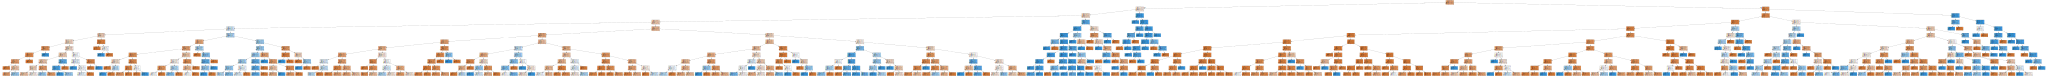

In [52]:
graphviz.Source(dot_data)

In [53]:
decision_tree.feature_importances_

array([ 0.0216051 ,  0.02180344,  0.10608106,  0.00206702,  0.05917532,
        0.38090773,  0.00284986,  0.00134651,  0.24358761,  0.0956483 ,
        0.06225424,  0.0026738 ])

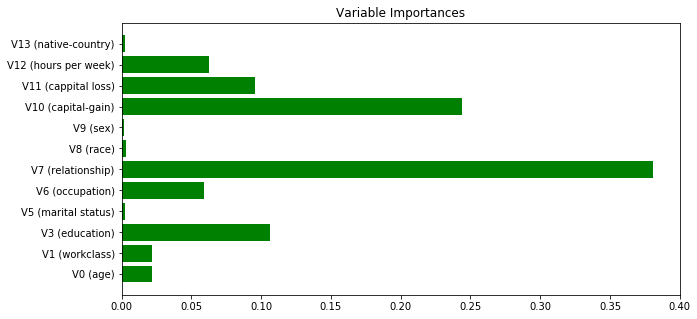

In [54]:
importances = decision_tree.feature_importances_
indices = np.arange(0, 12)

plt.figure(figsize=(10,5))
plt.title('Variable Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), ('V0 (age)', 'V1 (workclass)', 'V3 (education)', 
                                 'V5 (marital status)', 'V6 (occupation)', 'V7 (relationship)', 
                                 'V8 (race)', 'V9 (sex)', 'V10 (capital-gain)', 'V11 (cappital loss)', 
                                 'V12 (hours per week)', 'V13 (native-country)'));

As we can see the most important variables are `V7 (realtionship)`, `V10 (capital gain)` and `V3 education` affected on result more intensive than others.

# KNN

There is only 1 hyperparameter- number of neighbours. We use GridSearchCV for choosing an optimal `n_neighbors`. As metrics we use `minkowski` (euclidian metric).

In [55]:
knn = KNeighborsClassifier()

In [56]:
knn.fit(dummy_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [57]:
knn_pred = knn.predict(dummy_X_test)

In [58]:
accuracy_score(y_test, knn_pred)

0.78915962207856782

By default `n_neighbors=5`. Now tune it to find the best one.

In [59]:
tuned_param_knn = {'n_neighbors': np.arange(1, 20)}

In [60]:
knn_cv = GridSearchCV(knn, tuned_param_knn, cv=5, scoring='accuracy', n_jobs=-1)

In [61]:
%%time
knn_cv.fit(dummy_X_train, y_train)

CPU times: user 2.18 s, sys: 138 ms, total: 2.32 s
Wall time: 2min 58s


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [62]:
knn_cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

During 5-CV we find that the best `k_neighbors` equals 8. Compute the score the the best hyperparameter

In [63]:
knn_cv.best_score_

0.83538480666418002

We've got the `cv error rate` so far. Finally, compute accuracy score on the left-out dataset with the best value of hyperparameter `n_neighbors=8` to get unbiased result

In [64]:
knn = KNeighborsClassifier(n_neighbors=8)

In [65]:
knn.fit(dummy_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [66]:
knn_pred = knn.predict(dummy_left_out_X)

In [67]:
accuracy_score(left_out_y, knn_pred)

0.82788844621513946

The `test error rate` for left-out dataset equals 0.827 for 8 neatest neighbours.

## Ensemble Methods

Now we consider ensemble methods and start from typical ensemble methods such as bagging and random forest. Feature of ensembles comes down to using a bunch of models and averaging their result. It leads to decreasing the variance so the accuracy of the model increases.

### Bagging

Bagging uses bootstrap for creating $m$ different datasets from the origin. Unlike random forest it uses all variables. By default `n_estimators` equals 10. Bagging and random forest have no tendency to be overfitted due to different set of hyperparemeters `n_estimators`. So there is no need to make a `GridSearchCV` for searching the best one.

We set `n_estimators` equals 500

In [68]:
bagging = BaggingClassifier(n_jobs=-1, n_estimators=500, random_state=17)

In [69]:
%%time
bagging = bagging.fit(dummy_X_train, y_train)

CPU times: user 304 ms, sys: 1.55 s, total: 1.86 s
Wall time: 17.5 s


In [70]:
bagging_pred = bagging.predict(dummy_X_test)

In [71]:
accuracy_score(y_test, bagging_pred)

0.8030830432620587

As we did before compute the accuracy score on the `left_out` dataset

In [72]:
bagging_pred = bagging.predict(dummy_left_out_X)

In [73]:
accuracy_score(left_out_y, bagging_pred)

0.82928286852589639

As we cen see accuracy increased to 0.83. Nevertheless, we lost interpretability due to application of the ensembles.

## Random Forest

As I mentioned above, the random forest uses subset of original variables. By default we use $\sqrt{m}$ variables.

In [74]:
random_forest = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=17)

In [75]:
%%time
random_forest = random_forest.fit(dummy_X_train, y_train)

CPU times: user 10.1 s, sys: 349 ms, total: 10.4 s
Wall time: 5.56 s


In [76]:
random_forest_pred = random_forest.predict(dummy_X_test)

In [77]:
accuracy_score(y_test, random_forest_pred)

0.80407757334659369

As we did before compute the accuracy score on the `left_out` dataset

In [78]:
random_forest_pred = random_forest.predict(dummy_left_out_X)

In [79]:
accuracy_score(left_out_y, random_forest_pred)

0.83572377158034528

Even though we lost interpretability due to application of ensembles the accuracy score increased to 0.8357. It was achieved due to using $\sqrt{m}$ variables. Thus correaltion between variables has been decreased.

Now look on variables importances for RF

In [80]:
random_forest.feature_importances_

array([ 0.05881149,  0.06563922,  0.11158871,  0.08594215,  0.11754878,
        0.1380875 ,  0.02495958,  0.01512445,  0.16423515,  0.05730933,
        0.14829309,  0.01246054])

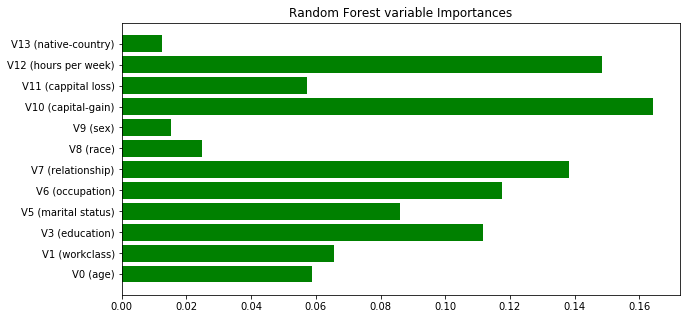

In [81]:
importances = random_forest.feature_importances_
indices = np.arange(0, 12)

plt.figure(figsize=(10,5))
plt.title('Random Forest variable Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), ('V0 (age)', 'V1 (workclass)', 'V3 (education)', 
                                 'V5 (marital status)', 'V6 (occupation)', 'V7 (relationship)', 
                                 'V8 (race)', 'V9 (sex)', 'V10 (capital-gain)', 'V11 (cappital loss)', 
                                 'V12 (hours per week)', 'V13 (native-country)'));

You might remember variable importances for decision tree classifier. Unlike decision tree, RF indicated less level for each variable, but almost all of them matters. `V7 (realtionship)`, `V10 (capital gain)` still have higher rate. In addition, `V12 (hours per week)` seem to be as much important as `V10 (capital gain)`.

## My customized ensembles

Customized ensembles are similar to bagging and random forest cause bootstap uses as well for creating a bunch of datasets from the origin. Unlike RF and Bagging, we use not just decision tree but anyone models we want. This approach (ensemble) will make our final decision more robust, accurate and less likely to be biased. As I mentioned in RF, using of ensemble decreases variance but also decreases interpretability.

### Averaging

There are different approches to creating ensembles. it might combine different model and averaging their results/probabilities. Another aproach called weighted average. In this case different weights are applied to predict from multiple models then taking the average which means giving high or low importance to specific model output so as to amplify or weaken certain model in ensemble.

Here we consider averaging. The first step comes down to finding probability for previously created models on the **test set** (It's vital to get `test error rate`). Here we use 3 models: `logit`, `knn` and `tree`. We can increase ensemble accuracy by using well-tuned models.

Find a vector of probabilites for each model on the test set.

#### Logit

In [82]:
logit_pred_prob = logit.predict_proba(dummy_left_out_X)[:,0]

In [83]:
logit_pred_prob

array([ 0.91702309,  0.69815141,  0.5975885 , ...,  0.64686262,
        0.2332261 ,  0.64150279])

#### Decision tree

In [84]:
tree_pred_prob = decision_tree.predict_proba(dummy_left_out_X)[:,0]

In [85]:
tree_pred_prob

array([ 0.99854967,  0.66933333,  0.64220183, ...,  0.27050611,
        1.        ,  0.27050611])

#### KNN

In [86]:
knn_pred_prob = knn.predict_proba(dummy_left_out_X)[:,0]

In [87]:
knn_pred_prob

array([ 1.   ,  0.75 ,  0.25 , ...,  0.125,  0.5  ,  0.125])

#### Averaging

Now we should average corresponding probabilities of 3 vectors

In [88]:
average_pred_prob = (logit_pred_prob+tree_pred_prob+knn_pred_prob)/3

In [89]:
average_pred_prob

array([ 0.97185759,  0.70582825,  0.49659678, ...,  0.34745624,
        0.57774203,  0.34566963])

On the next step we transform vector of probabilities to vector of strings with ` <=50K`, ` >50K` depends on the value of probability. The threshould of probability equals `0.5`

In [90]:
average_pred = np.where(average_pred_prob > 0.5, ' <=50K', ' >50K')

In [91]:
average_pred

array([' <=50K', ' <=50K', ' >50K', ..., ' >50K', ' <=50K', ' >50K'], 
      dtype='<U6')

In [92]:
accuracy_score(left_out_y, average_pred)

0.83950863213811422

Our customized ensemble give the best result compared with Random Forest! `0.84`

### Avoid correlation

There is one important thing which must be fulfilled. The correlation between chosen model should be as small as possible. This condition increases an accuracy of the model. 

Let's examine the correlation between 3 models. As preprocessing for creating the correlation matrix we should transform vectors of probabilites to binary vector with `0` and `1` values. The threshould remains the same `0.5`.

In [93]:
logit_binary_response = np.where(logit_pred_prob > 0.5, 0, 1)

In [94]:
tree_binary_response = np.where(tree_pred_prob > 0.5, 0, 1)

In [95]:
knn_binary_response = np.where(knn_pred_prob > 0.5, 0, 1)

Merge 3 vectors into 1 dataframe

In [96]:
df = pd.DataFrame({'logit': logit_binary_response, 'tree': tree_binary_response, 'knn': knn_binary_response})

And construct the correlation matrix

In [97]:
df.corr()

,knn,logit,tree
knn,1.000000,0.383817,0.652625
logit,0.383817,1.000000,0.386359
tree,0.652625,0.386359,1.000000


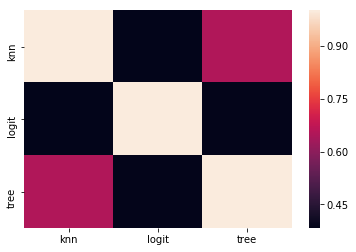

In [98]:
sns.heatmap(df.corr());

`KNN` and `Tree` are highly correlated. I have skipped checking for the correlation between the predictions of the three models. I have randomly chosen these three models for a demonstration of the concepts. If the predictions are highly correlated, then using these three might not give better results than individual models. But you got the point. After all, the accuracy of the customized ensemble is still the highest throughout all models.

### Stacking

In stacking multiple layers of machine learning models are placed one over another where each of the models passes their predictions to the model in the layer above it and the top layer model takes decisions based on the outputs of the models in layers below it. Actually, it's a kind of a neural network. We have a graph with several layers and we are interested in optimizing loss funtion on each node. Outputs of each model from the first layer becomes input for the model on the second layer. In our case there are 2 layers and it's easier to understand what going on just looking on the image below.

<img src="https://drive.google.com/file/d/18U-a7vth6qOXLQyyqMgVfTn7XGBpKD8j/view?usp=sharing",width=60,height=60>

![Stacking](https://drive.google.com/open?id=18U-a7vth6qOXLQyyqMgVfTn7XGBpKD8j)

The following steps we'll take:
1. Train the individual base layer models on training data.
2. Predict using each base layer model for training data and test data.
3. Now train the top layer model again on the predictions of the bottom layer models that has been made on the training data.
4. Finally, predict using the top layer model with the predictions of bottom layer models that has been made for testing data.

Some of steps have already been done before, but just repeat them all step by step

1) Train the individual base layer models on training data.

#### logit

In [99]:
logit = linear_model.LogisticRegression(penalty='l1', C=0.001, random_state=17, n_jobs=-1)

In [100]:
logit.fit(dummy_X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Decision tree

In [101]:
decision_tree = tree.DecisionTreeClassifier(max_depth=11, random_state=17)

In [102]:
decision_tree.fit(dummy_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

#### KNN

In [103]:
knn = KNeighborsClassifier(n_neighbors=8)

In [104]:
knn.fit(dummy_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

2) Predict using each base layer model for training data and test data.

In [105]:
# training set
logit_train_pred = logit.predict_proba(dummy_X_train)[:, 0]

In [106]:
tree_train_pred = decision_tree.predict_proba(dummy_X_train)[:, 0]

In [107]:
knn_train_pred = knn.predict_proba(dummy_X_train)[:, 0]

In [108]:
# test set
logit_test_pred = logit.predict_proba(dummy_X_test)[:, 0]

In [109]:
tree_test_pred = decision_tree.predict_proba(dummy_X_test)[:, 0]

In [110]:
knn_test_pred = knn.predict_proba(dummy_X_test)[:, 0]

3) Now train the top layer model again on the predictions of the bottom layer models that has been made on the training data.

For top layer model we are gonna use Gradient Boosting Classifier. At first, combine 3 output vectors into training and test datasets correspondingly. This output dataframes will be used as inputs for boosting classifier

In [111]:
boosting_train = pd.DataFrame({'logit_train': logit_train_pred, 'tree_train': tree_train_pred, 'knn_train': knn_train_pred})

In [112]:
boosting_test = pd.DataFrame({'logit_test': logit_test_pred, 'tree_test': tree_test_pred, 'knn_test': knn_test_pred})

In [113]:
gbm = GradientBoostingClassifier()

In [114]:
gbm = gbm.fit(boosting_train, y_train)

4) Finally, predict using the top layer model with the predictions of bottom layer models that has been made for testing data.

In [115]:
gbm_pred = gbm.predict(boosting_test)

In [116]:
accuracy_score(y_test, gbm_pred)

0.80573512348748555